# Hello

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.optim as optim


from sklearn.preprocessing import OneHotEncoder, LabelEncoder

## Load Data

In [2]:
#load .npz-file from folder
data_folder = "data/"
loader = np.load(data_folder+"gray_image_data_xs.npz")
train_data = loader["train_features"]
train_labels = loader["train_labels"].reshape((-1,1))
val_data = loader["val_features"]
val_labels = loader["val_labels"].reshape((-1,1))

labels_length = train_labels.shape[0]
all_labels = np.append(train_labels, val_labels)
# numeric encoding
en = LabelEncoder()
all_labels = en.fit_transform(all_labels)
train_labels = all_labels[:labels_length]
val_labels = all_labels[labels_length:]
num_classes = max(train_labels)+1

train_data = np.expand_dims(train_data, axis=1)
val_data = np.expand_dims(val_data, axis=1)

In [3]:
train_data.shape

(800, 1, 100, 100)

In [4]:
train_labels.shape

(800,)

## Load data for pytorch

In [5]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        #super(MyDataset, self).__init__()
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [6]:
train = MyDataset(train_data, train_labels)
train_loader = DataLoader(train, batch_size=64, shuffle=True)

val = MyDataset(val_data, train_labels)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

## Build Model

In [7]:
import time

In [8]:
# the Classifier stolen from Pytorch Tutorial
class CNN(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        
        self.fc1 = nn.Linear(32*22*22 , 64)
        self.fc2 = nn.Linear(64, num_classes)
        
        self.dropout = nn.Dropout(p=dropout)
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):

        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.dropout(self.fc1(x)))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def make_plot(self):
        train_acc_dropoutreg = self.hist['train_accuracy'][-1]
        val_acc_dropoutreg = self.hist['val_accuracy'][-1]

        print("dr:",f"{train_acc_dropoutreg:.3f}",f"{val_acc_dropoutreg:.3f}")

        print(epochs, batch_size, learning_rate)
        print("maxacc,minloss at epoch: ", np.argmax(self.hist['val_accuracy']),np.argmin(self.hist['val_loss']),\
              "acc there: ", self.hist['val_accuracy'][np.argmax(self.hist['val_accuracy'])],\
             self.hist['val_accuracy'][np.argmin(self.hist['val_loss'])])

        plt.figure(figsize=(10,5))

        plt.plot(self.hist['train_loss'][0::], 
                 label="Training (dropout regularization)")
        plt.plot(self.hist['val_loss'][0::], 
                 label="Validation (dropout regularization)", linestyle="--")
        
        plt.xlabel("Epoch", fontsize=20)
        plt.ylabel("Loss", fontsize=20)
        plt.legend()
        plt.show()
            
    def train(self, train_data, train_labels, val_data, val_labels, epochs=20, dropout=0.0, batch_size=512):
        train_losses, train_accs = [], []
        val_losses, val_accs = [], []
        
        tr_loss, tr_acc = self.runForward(train_loader)
        val_loss, val_acc = self.runForward(val_loader)

        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        for epoch in range(epochs):  # loop over the dataset multiple times
            self.running_loss = 0.0
            self.run(train_loader)
            tr_loss, tr_acc = self.run(train_loader, backward=False)
            val_loss, val_acc = self.run(val_loader, backward=False)

            train_losses.append(tr_loss)
            train_accs.append(tr_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            self.hist={'train_loss': np.array(train_losses),
           'train_accuracy': np.array(train_accs),
           'val_loss': np.array(val_losses),
           'val_accuracy': np.array(val_accs)}
            
            if (epoch + 1) % 2 == 0:
                print(f"Epoch {epoch+1}/{epochs}")
                self.make_plot()

In [9]:
# hyperparams
epochs = 10
batch_size = 64
learning_rate = 0.001
dropout = 0.5

width, height = 100,100

In [10]:
# train model
t = time.time()
cnn = CNN(num_classes = num_classes)
#cnn.train(train_data, train_labels, val_data, val_labels, epochs=epochs, dropout=dropout, batch_size=batch_size)

optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        ti = time.time()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print("step",time.time() - ti)

        running_loss += loss.item()
        
        ###end batch
        
    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs}")
        #cnn.make_plot()

print('Finished Training', time.time()-t)

RuntimeError: _thnn_conv2d_forward is not implemented for type torch.ByteTensor

In [89]:
# evaluate model
plt.figure(figsize=(10,5))

plt.plot(cnn.hist['train_loss'][5::], 
         label="Training (dropout regularization)")
plt.plot(cnn.hist['val_loss'][5::], 
         label="Validation (dropout regularization)", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

AttributeError: 'CNN' object has no attribute 'hist'

<Figure size 720x360 with 0 Axes>

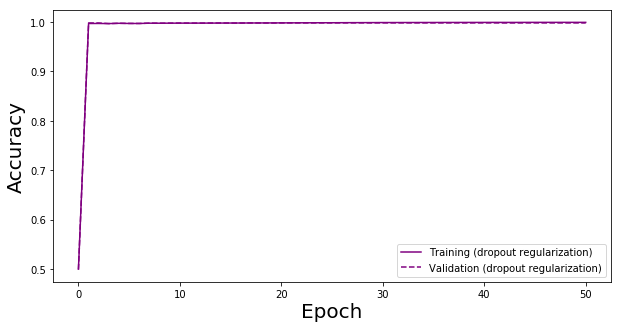

In [105]:
# Accuracy Plot
plt.figure(figsize=(10,5))

plt.plot(cnn.hist['train_accuracy'], 
         label="Training (dropout regularization)", color="purple")
plt.plot(cnn.hist['val_accuracy'], 
         label="Validation (dropout regularization)", color="purple", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()